# Cell 1 — Setup
## Настройка окружения

Эта ячейка загружает все необходимые библиотеки и устанавливает фиксированные значения случайных чисел, чтобы результаты эксперимента были воспроизводимыми.
Используемые библиотеки:

- TensorFlow / Keras — для построения и обучения нейросети;
- NumPy — для работы с массивами;
- Pandas — для организации данных в таблицах;
- Matplotlib — для визуализации;
- Scikit-learn — для разбиения данных и оценки точности.

Также фиксируются “seed” (зерна случайности), чтобы обучение можно было повторить с тем же результатом.

In [1]:
import os
os.environ["PYTHONHISTFILE"] = "/kaggle/working/python_history"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Reduce TensorFlow warnings

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import json
import pickle
import datetime

print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))

# Set seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

print("✓ Environment setup complete")

2025-12-09 08:27:45.181892: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765268865.377488      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765268865.432036      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

TensorFlow version: 2.18.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
✓ Environment setup complete


# Cell 2 — Build dataset dataframe
## Подготовка датафрейма с путями и метками
В этой ячейке мы:

1. Указываем путь к папке с изображениями из Stanford Dogs Dataset.
2. Собираем список всех подкаталогов — каждая папка соответствует породе собаки.
3. Проходим по всем файлам и составляем таблицу (DataFrame), где:
- filepath — полный путь к изображению;
- label — название породы.

Также удаляются лишние символы из названий (например, n02085620-Chihuahua → Chihuahua).

In [2]:
# Path to dataset
data_dir = '/kaggle/input/stanford-dogs-dataset/images/Images'

# Collect all breed folders
breed_folders = sorted([d for d in os.listdir(data_dir) 
                       if os.path.isdir(os.path.join(data_dir, d))])
print(f"Found {len(breed_folders)} breed folders")

filepaths, labels = [], []
valid_ext = {'.jpg', '.jpeg', '.png'}

for breed in breed_folders:
    breed_path = os.path.join(data_dir, breed)
    files = sorted([f for f in os.listdir(breed_path)
                    if os.path.splitext(f.lower())[1] in valid_ext])
    for f in files:
        filepaths.append(os.path.join(breed_path, f))
        labels.append(breed.split('-', 1)[1])

df = pd.DataFrame({'filepath': filepaths, 'label': labels})
print(f"Total images: {len(df)}")
print(f"Total classes: {df['label'].nunique()}")
print(f"Images per class: min={df['label'].value_counts().min()}, "
      f"max={df['label'].value_counts().max()}, "
      f"mean={df['label'].value_counts().mean():.1f}")

# Quick sanity check
display(df.head())

Found 120 breed folders
Total images: 20580
Total classes: 120
Images per class: min=148, max=252, mean=171.5


,filepath,label
0,/kaggle/input/stanford-dogs-dataset/images/Ima...,Chihuahua
1,/kaggle/input/stanford-dogs-dataset/images/Ima...,Chihuahua
2,/kaggle/input/stanford-dogs-dataset/images/Ima...,Chihuahua
3,/kaggle/input/stanford-dogs-dataset/images/Ima...,Chihuahua
4,/kaggle/input/stanford-dogs-dataset/images/Ima...,Chihuahua


# Cell 3 — Train/validation split
## Разделение данных на обучающую и валидационную выборки
Чтобы корректно обучить и оценить модель, весь набор изображений делится на две части:

- **Обучающая (training)** — 80% данных, используется для обучения сети;
- **Валидационная (validation)** — 20% данных, используется для проверки качества на невидимых примерах.

Используется параметр stratify, который обеспечивает равное соотношение классов (пород) в обеих выборках.

In [3]:
from collections import Counter

# Check class distribution
counts = Counter(df['label'])
min_count = min(counts.values())
print(f"Minimum images per class: {min_count}")

# Filter classes with too few images (only if needed)
few = [lbl for lbl, c in counts.items() if c < 2]
if few:
    print(f"⚠ Removing {len(few)} classes with <2 images: {few}")
    df = df[~df['label'].isin(few)]
else:
    print("✓ All classes have sufficient images (≥2) for stratified split")

# Stratified split
train_df, val_df = train_test_split(
    df, 
    test_size=0.2, 
    stratify=df['label'], 
    random_state=42
)

print(f"\nDataset split:")
print(f"  Train:      {len(train_df):5d} images ({len(train_df)/len(df)*100:.1f}%)")
print(f"  Validation: {len(val_df):5d} images ({len(val_df)/len(df)*100:.1f}%)")
print(f"  Total:      {len(df):5d} images")
print(f"\nClasses: Train={train_df['label'].nunique()}, Val={val_df['label'].nunique()}")

Minimum images per class: 148
✓ All classes have sufficient images (≥2) for stratified split

Dataset split:
  Train:      16464 images (80.0%)
  Validation:  4116 images (20.0%)
  Total:      20580 images

Classes: Train=120, Val=120


# Cell 4 — Image generators
## Создание генераторов изображений
Генераторы преобразуют изображения в поток данных, который можно “кормить” модели пакетами (batch).
Используем библиотеку ImageDataGenerator, которая также позволяет делать аугментацию данных — случайные изменения изображений, чтобы сеть не переобучалась.

- Для обучения включены случайные повороты, сдвиги, отражения и масштабирование.
- Для валидации выполняется только нормализация пикселей (приведение значений к диапазону 0–1).

Размер изображений выбран **224×224**, так как это стандартный вход для модели **MobileNetV2**.

In [4]:
IMG_SIZE = (224, 224)
BATCH = 32

# Training generator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.1,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation generator (only rescaling)
val_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_gen = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filepath',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

val_gen = val_datagen.flow_from_dataframe(
    val_df,
    x_col='filepath',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH,
    class_mode='categorical',
    shuffle=False
)

num_classes = len(train_gen.class_indices)
print(f"\n✓ Generators created")
print(f"  Number of classes: {num_classes}")
print(f"  Batch size: {BATCH}")
print(f"  Steps per epoch: train={len(train_gen)}, val={len(val_gen)}")

Found 16464 validated image filenames belonging to 120 classes.
Found 4116 validated image filenames belonging to 120 classes.

✓ Generators created
  Number of classes: 120
  Batch size: 32
  Steps per epoch: train=515, val=129


# Cell 5 — Model creation + training
## Создание и обучение модели
Здесь создаётся и обучается нейросеть с использованием Transfer Learning — метода, при котором используется уже обученная сеть в качестве основы.

1. Загружаем MobileNetV2, обученную на огромном наборе ImageNet.
Она уже умеет выделять универсальные признаки объектов (уши, шерсть, морда и т.д.).
2. Замораживаем веса базовой модели, чтобы не разрушить уже обученные параметры.

**Добавляем собственные слои:**
- GlobalAveragePooling2D() — уменьшает размер признаков;
- Dense(512, relu) — обучаемый слой для адаптации к породам собак;
- Dense(num_classes, softmax) — выходной слой для классификации 120 пород.

**Добавлены callbacks:**
- ModelCheckpoint — сохраняет лучшую модель;
- EarlyStopping — останавливает обучение, если качество перестало улучшаться;
- ReduceLROnPlateau — уменьшает скорость обучения при плато.

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Load pre-trained MobileNetV2
base_model = MobileNetV2(
    weights='imagenet', 
    include_top=False,
    input_shape=IMG_SIZE + (3,)
)
base_model.trainable = False  # Freeze base model

# Build custom classifier on top
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.2),
    Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dense(num_classes, activation='softmax')
])

# Compile with Top-5 accuracy metric
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.TopKCategoricalAccuracy(k=5, name='top5_acc')
    ]
)

print("Model Architecture:")
model.summary()

print(f"\nTrainable parameters: {sum([tf.size(w).numpy() for w in model.trainable_weights]):,}")
print(f"Non-trainable parameters: {sum([tf.size(w).numpy() for w in model.non_trainable_weights]):,}")

# Setup callbacks
callbacks = [
    ModelCheckpoint(
        'best_model.h5', 
        monitor='val_accuracy', 
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss', 
        patience=7,
        restore_best_weights=True, 
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.5, 
        patience=3,
        min_lr=1e-7,
        verbose=1
    )
]

# Train the model
print("\n" + "="*60)
print("STAGE 1: Transfer Learning (frozen base model)")
print("="*60)

EPOCHS = 20
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

print("\n✓ Training completed")
print(f"Best validation accuracy: {max(history.history['val_accuracy']):.4f}")

I0000 00:00:1765268936.916591      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 120)            │        30,840 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,616,760 (9.98 MB)

 Trainable params: 358,776 (1.37 MB)

 Non-trainable params: 2,257,984 (8.61 MB)


Trainable parameters: 358,776
Non-trainable parameters: 2,257,984

STAGE 1: Transfer Learning (frozen base model)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


I0000 00:00:1765268947.026665     105 service.cc:148] XLA service 0x7e3f6c1435a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765268947.027560     105 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1765268947.983567     105 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/515 ━━━━━━━━━━━━━━━━━━━━ 1:30:10 11s/step - accuracy: 0.0000e+00 - loss: 9.4772 - top5_acc: 0.0000e+00

I0000 00:00:1765268952.217550     105 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 540ms/step - accuracy: 0.3487 - loss: 5.9966 - top5_acc: 0.5865
Epoch 1: val_accuracy improved from -inf to 0.70019, saving model to best_model.h5


515/515 ━━━━━━━━━━━━━━━━━━━━ 326s 614ms/step - accuracy: 0.3490 - loss: 5.9933 - top5_acc: 0.5869 - val_accuracy: 0.7002 - val_loss: 2.3465 - val_top5_acc: 0.9402 - learning_rate: 5.0000e-04
Epoch 2/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step - accuracy: 0.6549 - loss: 2.2543 - top5_acc: 0.9227
Epoch 2: val_accuracy improved from 0.70019 to 0.71526, saving model to best_model.h5


515/515 ━━━━━━━━━━━━━━━━━━━━ 194s 377ms/step - accuracy: 0.6549 - loss: 2.2540 - top5_acc: 0.9227 - val_accuracy: 0.7153 - val_loss: 1.6513 - val_top5_acc: 0.9531 - learning_rate: 5.0000e-04
Epoch 3/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - accuracy: 0.6840 - loss: 1.7084 - top5_acc: 0.9334
Epoch 3: val_accuracy improved from 0.71526 to 0.72255, saving model to best_model.h5


515/515 ━━━━━━━━━━━━━━━━━━━━ 194s 376ms/step - accuracy: 0.6840 - loss: 1.7084 - top5_acc: 0.9334 - val_accuracy: 0.7225 - val_loss: 1.4797 - val_top5_acc: 0.9534 - learning_rate: 5.0000e-04
Epoch 4/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - accuracy: 0.6916 - loss: 1.5630 - top5_acc: 0.9367
Epoch 4: val_accuracy did not improve from 0.72255
515/515 ━━━━━━━━━━━━━━━━━━━━ 197s 383ms/step - accuracy: 0.6916 - loss: 1.5630 - top5_acc: 0.9366 - val_accuracy: 0.7177 - val_loss: 1.4199 - val_top5_acc: 0.9509 - learning_rate: 5.0000e-04
Epoch 5/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step - accuracy: 0.6990 - loss: 1.5006 - top5_acc: 0.9384
Epoch 5: val_accuracy did not improve from 0.72255
515/515 ━━━━━━━━━━━━━━━━━━━━ 195s 379ms/step - accuracy: 0.6989 - loss: 1.5006 - top5_acc: 0.9384 - val_accuracy: 0.6966 - val_loss: 1.4435 - val_top5_acc: 0.9436 - learning_rate: 5.0000e-04
Epoch 6/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step - accuracy: 0.6979 - loss: 1.4575 - top5_acc: 0.9420
Epoc

515/515 ━━━━━━━━━━━━━━━━━━━━ 192s 374ms/step - accuracy: 0.7055 - loss: 1.4163 - top5_acc: 0.9430 - val_accuracy: 0.7228 - val_loss: 1.3375 - val_top5_acc: 0.9497 - learning_rate: 5.0000e-04
Epoch 9/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step - accuracy: 0.7118 - loss: 1.3965 - top5_acc: 0.9441
Epoch 9: val_accuracy improved from 0.72279 to 0.73032, saving model to best_model.h5


515/515 ━━━━━━━━━━━━━━━━━━━━ 194s 378ms/step - accuracy: 0.7117 - loss: 1.3966 - top5_acc: 0.9440 - val_accuracy: 0.7303 - val_loss: 1.3218 - val_top5_acc: 0.9519 - learning_rate: 5.0000e-04
Epoch 10/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step - accuracy: 0.7147 - loss: 1.3843 - top5_acc: 0.9425
Epoch 10: val_accuracy did not improve from 0.73032
515/515 ━━━━━━━━━━━━━━━━━━━━ 194s 377ms/step - accuracy: 0.7147 - loss: 1.3844 - top5_acc: 0.9425 - val_accuracy: 0.7199 - val_loss: 1.3204 - val_top5_acc: 0.9519 - learning_rate: 5.0000e-04
Epoch 11/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step - accuracy: 0.7067 - loss: 1.4063 - top5_acc: 0.9414
Epoch 11: val_accuracy did not improve from 0.73032
515/515 ━━━━━━━━━━━━━━━━━━━━ 195s 378ms/step - accuracy: 0.7067 - loss: 1.4063 - top5_acc: 0.9414 - val_accuracy: 0.7123 - val_loss: 1.3111 - val_top5_acc: 0.9536 - learning_rate: 5.0000e-04
Epoch 12/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - accuracy: 0.7078 - loss: 1.3795 - top5_acc: 0.9441

# Cell 6 — Fine-tune last layers
## Тонкая настройка
На этом этапе мы “размораживаем” часть слоёв базовой модели, чтобы дообучить их на нашем наборе данных.
Это помогает повысить точность, особенно если набор изображений отличается от оригинального ImageNet.

In [10]:
# Unfreeze the last 30 layers of base model
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

trainable_count = sum([1 for layer in base_model.layers if layer.trainable])
print(f"Base model layers: {len(base_model.layers)}")
print(f"Trainable layers in base_model: {trainable_count}")

# Recompile with lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.TopKCategoricalAccuracy(k=5, name='top5_acc')
    ]
)

print("\n" + "="*60)
print("STAGE 2: Fine-tuning (last 30 layers unfrozen)")
print("="*60)

# Fine-tune
fine_history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=callbacks,
    verbose=1
)

# CRITICAL: Merge training histories
print("\n✓ Merging training histories...")
for key in history.history.keys():
    history.history[key].extend(fine_history.history[key])

total_epochs = len(history.history['loss'])
print(f"✓ Fine-tuning completed")
print(f"Total epochs trained: {total_epochs}")
print(f"Best validation accuracy: {max(history.history['val_accuracy']):.4f}")
print(f"Best Top-5 accuracy: {max(history.history['val_top5_acc']):.4f}")

Base model layers: 154
Trainable layers in base_model: 30

STAGE 2: Fine-tuning (last 30 layers unfrozen)
Epoch 1/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step - accuracy: 0.7882 - loss: 1.0024 - top5_acc: 0.9752
Epoch 1: val_accuracy improved from 0.76190 to 0.76531, saving model to best_model.h5


515/515 ━━━━━━━━━━━━━━━━━━━━ 213s 386ms/step - accuracy: 0.7882 - loss: 1.0024 - top5_acc: 0.9752 - val_accuracy: 0.7653 - val_loss: 1.0617 - val_top5_acc: 0.9638 - learning_rate: 1.0000e-05
Epoch 2/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - accuracy: 0.8013 - loss: 0.9917 - top5_acc: 0.9728
Epoch 2: val_accuracy improved from 0.76531 to 0.76652, saving model to best_model.h5


515/515 ━━━━━━━━━━━━━━━━━━━━ 192s 372ms/step - accuracy: 0.8013 - loss: 0.9917 - top5_acc: 0.9728 - val_accuracy: 0.7665 - val_loss: 1.0593 - val_top5_acc: 0.9648 - learning_rate: 1.0000e-05
Epoch 3/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - accuracy: 0.8068 - loss: 0.9642 - top5_acc: 0.9750
Epoch 3: val_accuracy did not improve from 0.76652
515/515 ━━━━━━━━━━━━━━━━━━━━ 190s 370ms/step - accuracy: 0.8068 - loss: 0.9642 - top5_acc: 0.9750 - val_accuracy: 0.7646 - val_loss: 1.0549 - val_top5_acc: 0.9638 - learning_rate: 1.0000e-05
Epoch 4/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step - accuracy: 0.8045 - loss: 0.9624 - top5_acc: 0.9736
Epoch 4: val_accuracy improved from 0.76652 to 0.76944, saving model to best_model.h5


515/515 ━━━━━━━━━━━━━━━━━━━━ 190s 369ms/step - accuracy: 0.8045 - loss: 0.9624 - top5_acc: 0.9736 - val_accuracy: 0.7694 - val_loss: 1.0375 - val_top5_acc: 0.9660 - learning_rate: 1.0000e-05
Epoch 5/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - accuracy: 0.8149 - loss: 0.9257 - top5_acc: 0.9789
Epoch 5: val_accuracy did not improve from 0.76944
515/515 ━━━━━━━━━━━━━━━━━━━━ 190s 369ms/step - accuracy: 0.8149 - loss: 0.9257 - top5_acc: 0.9789 - val_accuracy: 0.7641 - val_loss: 1.0406 - val_top5_acc: 0.9665 - learning_rate: 1.0000e-05
Epoch 6/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - accuracy: 0.8129 - loss: 0.9223 - top5_acc: 0.9800
Epoch 6: val_accuracy improved from 0.76944 to 0.77089, saving model to best_model.h5


515/515 ━━━━━━━━━━━━━━━━━━━━ 191s 371ms/step - accuracy: 0.8129 - loss: 0.9223 - top5_acc: 0.9800 - val_accuracy: 0.7709 - val_loss: 1.0285 - val_top5_acc: 0.9662 - learning_rate: 1.0000e-05
Epoch 7/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step - accuracy: 0.8236 - loss: 0.9088 - top5_acc: 0.9789
Epoch 7: val_accuracy improved from 0.77089 to 0.77357, saving model to best_model.h5


515/515 ━━━━━━━━━━━━━━━━━━━━ 192s 372ms/step - accuracy: 0.8236 - loss: 0.9089 - top5_acc: 0.9789 - val_accuracy: 0.7736 - val_loss: 1.0282 - val_top5_acc: 0.9657 - learning_rate: 1.0000e-05
Epoch 8/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - accuracy: 0.8182 - loss: 0.8961 - top5_acc: 0.9800
Epoch 8: val_accuracy did not improve from 0.77357
515/515 ━━━━━━━━━━━━━━━━━━━━ 191s 371ms/step - accuracy: 0.8182 - loss: 0.8961 - top5_acc: 0.9800 - val_accuracy: 0.7697 - val_loss: 1.0202 - val_top5_acc: 0.9660 - learning_rate: 1.0000e-05
Epoch 9/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - accuracy: 0.8244 - loss: 0.8856 - top5_acc: 0.9820
Epoch 9: val_accuracy did not improve from 0.77357
515/515 ━━━━━━━━━━━━━━━━━━━━ 196s 381ms/step - accuracy: 0.8244 - loss: 0.8856 - top5_acc: 0.9820 - val_accuracy: 0.7685 - val_loss: 1.0208 - val_top5_acc: 0.9653 - learning_rate: 1.0000e-05
Epoch 10/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step - accuracy: 0.8285 - loss: 0.8590 - top5_acc: 0.9841
Epo

# Cell 7 — Save everything
## Сохранение артефактов
Сохраняем модель, маппинг классов, историю обучения и метаданные.

Это необходимо, чтобы можно было воспроизвести результаты или загрузить модель в другой среде.

In [11]:
# Save model
model.save('dog_breed_classifier.h5')
print("✓ Model saved: dog_breed_classifier.h5")

# Save class indices with formatting
with open('class_indices.json', 'w') as f:
    json.dump(train_gen.class_indices, f, indent=2)
print("✓ Class indices saved: class_indices.json")

# Save training history
with open('history.pkl', 'wb') as f:
    pickle.dump(history.history, f)
print("✓ Training history saved: history.pkl")

# Save training metadata
metadata = {
    'training_date': datetime.datetime.now().isoformat(),
    'total_images': len(df),
    'train_images': len(train_df),
    'val_images': len(val_df),
    'num_classes': num_classes,
    'img_size': IMG_SIZE,
    'batch_size': BATCH,
    'total_epochs': len(history.history['loss']),
    'architecture': 'MobileNetV2 + Custom Head',
    'base_model_trainable_layers': trainable_count,
    'final_metrics': {
        'train_accuracy': float(history.history['accuracy'][-1]),
        'val_accuracy': float(history.history['val_accuracy'][-1]),
        'train_loss': float(history.history['loss'][-1]),
        'val_loss': float(history.history['val_loss'][-1]),
        'best_val_accuracy': float(max(history.history['val_accuracy'])),
        'best_val_top5_accuracy': float(max(history.history['val_top5_acc']))
    }
}

with open('training_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)
print("✓ Training metadata saved: training_metadata.json")

print("\n" + "="*60)
print("All artifacts saved successfully!")
print("="*60)

✓ Model saved: dog_breed_classifier.h5
✓ Class indices saved: class_indices.json
✓ Training history saved: history.pkl
✓ Training metadata saved: training_metadata.json

All artifacts saved successfully!



*Теперь все результаты обучения сохранены.Файлы можно загрузить из папки /kaggle/working/ и использовать для последующих предсказаний без повторного обучения.*


# Cell 8 — Plot training curves
## Визуализация хода обучения
Строим графики изменения точности (accuracy) и потерь (loss) на протяжении всех эпох обучения
.
Это помогает визуально оценить, насколько хорошо сеть обучалась и не произошло ли переобучение.

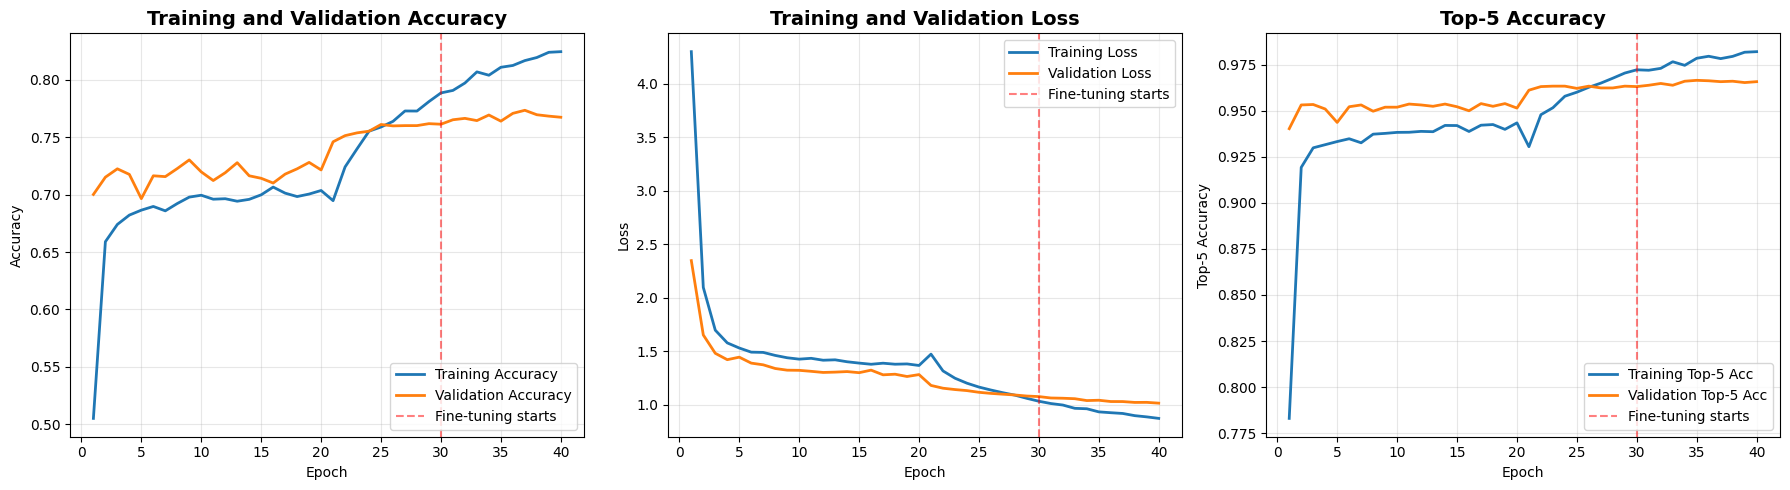


✓ Training curves saved: training_curves.png


In [12]:
# Retrieve metrics
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
top5_acc = history.history['top5_acc']
val_top5_acc = history.history['val_top5_acc']

epochs_range = range(1, len(acc) + 1)

# Create figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Accuracy
axes[0].plot(epochs_range, acc, label='Training Accuracy', linewidth=2)
axes[0].plot(epochs_range, val_acc, label='Validation Accuracy', linewidth=2)
axes[0].axvline(x=len(acc)-10, color='red', linestyle='--', alpha=0.5, label='Fine-tuning starts')
axes[0].legend(loc='lower right')
axes[0].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].grid(True, alpha=0.3)

# Plot 2: Loss
axes[1].plot(epochs_range, loss, label='Training Loss', linewidth=2)
axes[1].plot(epochs_range, val_loss, label='Validation Loss', linewidth=2)
axes[1].axvline(x=len(loss)-10, color='red', linestyle='--', alpha=0.5, label='Fine-tuning starts')
axes[1].legend(loc='upper right')
axes[1].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].grid(True, alpha=0.3)

# Plot 3: Top-5 Accuracy
axes[2].plot(epochs_range, top5_acc, label='Training Top-5 Acc', linewidth=2)
axes[2].plot(epochs_range, val_top5_acc, label='Validation Top-5 Acc', linewidth=2)
axes[2].axvline(x=len(top5_acc)-10, color='red', linestyle='--', alpha=0.5, label='Fine-tuning starts')
axes[2].legend(loc='lower right')
axes[2].set_title('Top-5 Accuracy', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Top-5 Accuracy')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Training curves saved: training_curves.png")

# Cell 9 — Evaluation metrics
## Оценка модели
Для оценки качества модели используем:

- Classification Report — метрики точности (precision), полноты (recall) и F1 по каждому классу;
- Confusion Matrix — показывает, какие породы чаще всего путает модель.
- Top-5 Accuracy

Это помогает понять, какие породы требуют улучшения (например, визуально похожие).


Generating predictions on validation set...
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step

CLASSIFICATION REPORT
                                precision    recall  f1-score   support

                  Afghan_hound      0.849     0.938     0.891        48
           African_hunting_dog      0.971     0.971     0.971        34
                      Airedale      0.771     0.675     0.720        40
American_Staffordshire_terrier      0.647     0.667     0.657        33
                   Appenzeller      0.654     0.567     0.607        30
            Australian_terrier      0.644     0.744     0.690        39
            Bedlington_terrier      0.917     0.917     0.917        36
          Bernese_mountain_dog      0.837     0.932     0.882        44
              Blenheim_spaniel      0.944     0.895     0.919        38
                 Border_collie      0.632     0.800     0.706        30
                Border_terrier      0.906     0.853     0.879        34
                   Boston

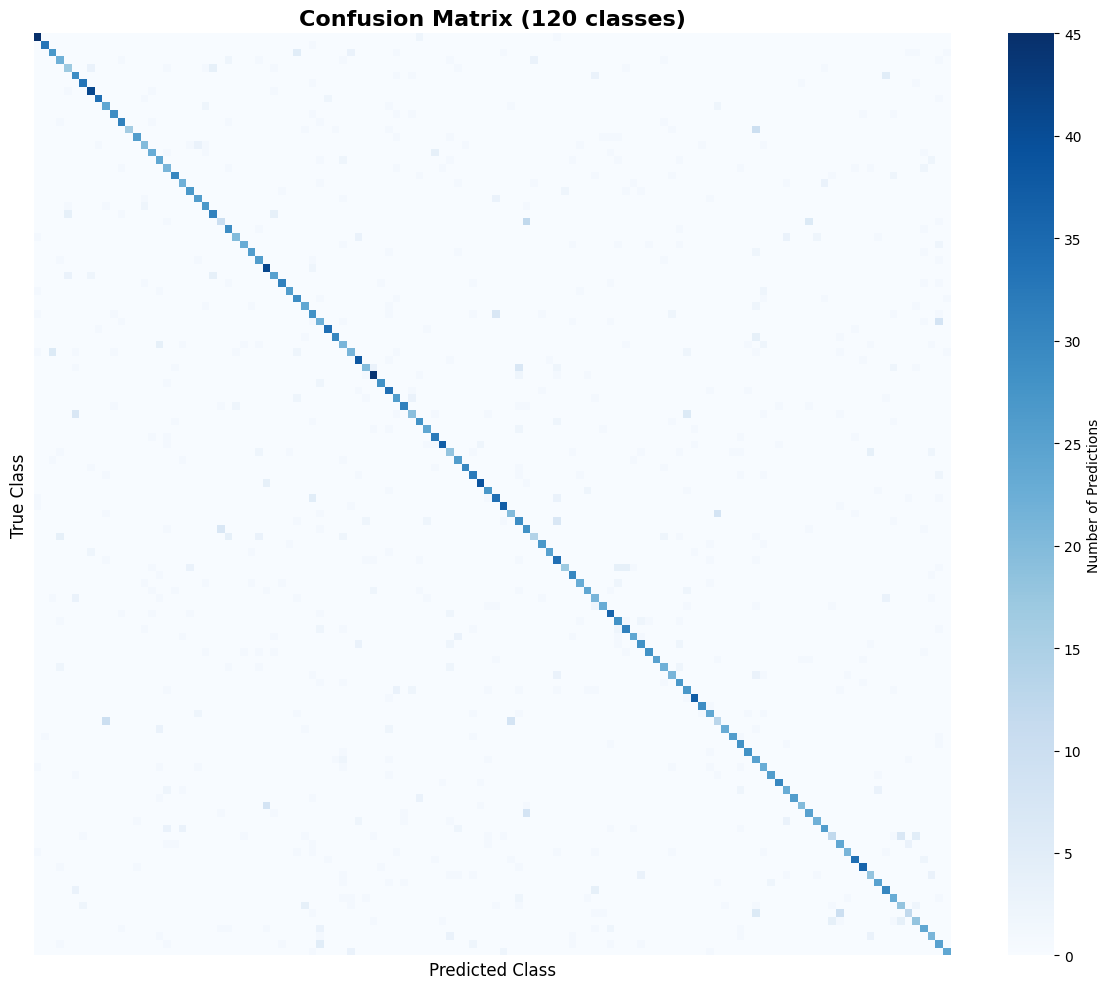


PER-CLASS ACCURACY ANALYSIS

📉 10 Worst Performing Breeds:
  Eskimo_dog                          - Accuracy: 0.333 ( 30 samples)
  miniature_poodle                    - Accuracy: 0.387 ( 31 samples)
  standard_schnauzer                  - Accuracy: 0.387 ( 31 samples)
  collie                              - Accuracy: 0.419 ( 31 samples)
  Staffordshire_bullterrier           - Accuracy: 0.452 ( 31 samples)
  Norwich_terrier                     - Accuracy: 0.514 ( 37 samples)
  Rhodesian_ridgeback                 - Accuracy: 0.529 ( 34 samples)
  Bouvier_des_Flandres                - Accuracy: 0.533 ( 30 samples)
  Lakeland_terrier                    - Accuracy: 0.538 ( 39 samples)
  Lhasa                               - Accuracy: 0.541 ( 37 samples)

📈 10 Best Performing Breeds:
  Sealyham_terrier                    - Accuracy: 0.925 ( 40 samples)
  Bernese_mountain_dog                - Accuracy: 0.932 ( 44 samples)
  flat-coated_retriever               - Accuracy: 0.933 ( 30 samples)


In [20]:
from sklearn.metrics import (classification_report, confusion_matrix, 
                             top_k_accuracy_score, accuracy_score)
import seaborn as sns
import numpy as np # Ensure numpy is available

# Verify val_gen exists
if 'val_gen' not in globals():
    raise RuntimeError("val_gen not found. Please run Cell 4 first.")

# Generate predictions
print("Generating predictions on validation set...")
val_gen.reset()
preds = model.predict(val_gen, verbose=1)
y_pred = np.argmax(preds, axis=1)

# --- FIX: Convert list to numpy array explicitly ---
y_true = np.array(val_gen.classes) 

# Get class names
target_names = [k for k, v in sorted(train_gen.class_indices.items(), key=lambda x: x[1])]

# Classification Report
print("\n" + "="*60)
print("CLASSIFICATION REPORT")
print("="*60)
print(classification_report(
    y_true, 
    y_pred,
    target_names=target_names,
    zero_division=0,
    digits=3
))

# Overall Metrics
print("\n" + "="*60)
print("OVERALL METRICS")
print("="*60)
top1_acc = accuracy_score(y_true, y_pred)
top5_acc = top_k_accuracy_score(y_true, preds, k=5)
print(f"Top-1 Accuracy: {top1_acc:.4f} ({top1_acc*100:.2f}%)")
print(f"Top-5 Accuracy: {top5_acc:.4f} ({top5_acc*100:.2f}%)")
print("="*60)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(
    cm, 
    cmap='Blues', 
    xticklabels=False, 
    yticklabels=False,
    cbar_kws={'label': 'Number of Predictions'}
)
plt.title(f'Confusion Matrix ({num_classes} classes)', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Class', fontsize=12)
plt.ylabel('True Class', fontsize=12)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Per-class accuracy analysis
print("\n" + "="*60)
print("PER-CLASS ACCURACY ANALYSIS")
print("="*60)

class_accuracies = []
for i, breed in enumerate(target_names):
    # Now this works because y_true is a numpy array
    mask = y_true == i
    count = np.sum(mask) # Safer numpy sum
    
    if count > 0:
        breed_acc = accuracy_score(y_true[mask], y_pred[mask])
        class_accuracies.append((breed, breed_acc, count))

class_accuracies.sort(key=lambda x: x[1])

print("\n📉 10 Worst Performing Breeds:")
for breed, acc, count in class_accuracies[:10]:
    print(f"  {breed:35s} - Accuracy: {acc:.3f} ({count:3d} samples)")

print("\n📈 10 Best Performing Breeds:")
for breed, acc, count in class_accuracies[-10:]:
    print(f"  {breed:35s} - Accuracy: {acc:.3f} ({count:3d} samples)")

print("\n✓ Evaluation complete")

# Cell 10 — Single-image prediction
## Предсказание новой фотографии
Загружается одно изображение собаки, выполняется предварительная обработка (изменение размера, нормализация).
Модель выдаёт вектор вероятностей для всех классов.
Берётся класс с наибольшей вероятностью, и результат визуализируется вместе с уровнем уверенности.

✓ Using class indices from train_gen
Random image selected:
  /kaggle/input/stanford-dogs-dataset/images/Images/n02098286-West_Highland_white_terrier/n02098286_2454.jpg
✓ Saved to 'shared_dog_image_path' for Cell 11 reuse


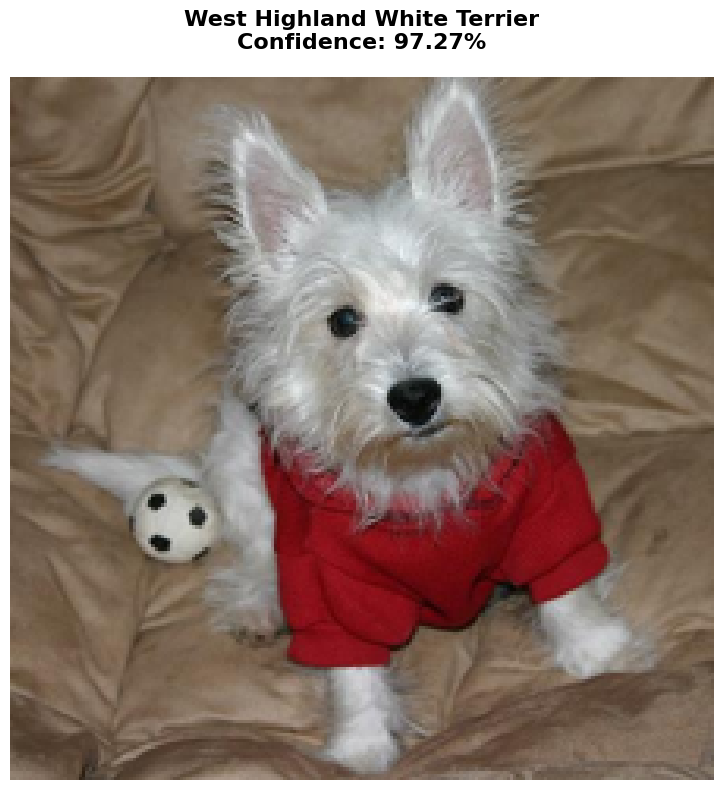


TOP-5 PREDICTIONS
1. West Highland White Terrier         0.973 ████████████████████████████████████████████████
2. Cairn                               0.010 
3. Maltese Dog                         0.006 
4. Scotch Terrier                      0.005 
5. Miniature Schnauzer                 0.001 

✓ Prediction saved: presentation_assets/single_prediction.png


In [39]:
import random
from PIL import Image
from tensorflow.keras.preprocessing import image

# Create output directory
os.makedirs('presentation_assets', exist_ok=True)

# 1. CREATE CLASS MAPPING
if 'train_gen' in globals() and hasattr(train_gen, 'class_indices'):
    inv_class_map = {v: k for k, v in train_gen.class_indices.items()}
    print("✓ Using class indices from train_gen")
elif os.path.exists('class_indices.json'):
    with open('class_indices.json', 'r') as f:
        class_map = json.load(f)
    inv_class_map = {v: k for k, v in class_map.items()}
    print("✓ Loaded class indices from file")
else:
    raise FileNotFoundError(
        "Cannot find class mapping! Options:\n"
        "1. Run Cell 4 to create train_gen\n"
        "2. Place class_indices.json in the working directory"
    )

IMG_SIZE = (224, 224)
DATA_DIR = '/kaggle/input/stanford-dogs-dataset/images/Images'

# 2. PICK RANDOM IMAGE
all_image_paths = []
for root, dirs, files in os.walk(DATA_DIR):
    for fname in files:
        if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
            all_image_paths.append(os.path.join(root, fname))

if len(all_image_paths) == 0:
    raise RuntimeError("No images found in dataset directory.")

# Save path for Cell 11 to reuse (no 'global' needed - cells share namespace)
shared_dog_image_path = random.choice(all_image_paths)
img_path = shared_dog_image_path
print(f"Random image selected:\n  {img_path}")
print(f"✓ Saved to 'shared_dog_image_path' for Cell 11 reuse")

# 3. LOAD & PREPROCESS
img_pil = Image.open(img_path).convert('RGB').resize(IMG_SIZE)
arr = image.img_to_array(img_pil) / 255.0
batch = np.expand_dims(arr, axis=0).astype(np.float32)

# 4. PREDICT
preds = model.predict(batch, verbose=0)
pred_idx = int(np.argmax(preds[0]))
pred_label = inv_class_map[pred_idx]
confidence = float(np.max(preds[0]))

# 5. DISPLAY
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(img_pil)
ax.axis('off')
ax.set_title(
    f"{pred_label.replace('_', ' ').title()}\nConfidence: {confidence:.2%}",
    fontsize=16,
    fontweight='bold',
    pad=20
)
plt.tight_layout()
plt.savefig('presentation_assets/single_prediction.png', dpi=300, bbox_inches='tight')
plt.show()

# 6. TOP-5 PREDICTIONS
print("\n" + "="*60)
print("TOP-5 PREDICTIONS")
print("="*60)
top5_idx = np.argsort(preds[0])[-5:][::-1]
for i, idx in enumerate(top5_idx, 1):
    breed = inv_class_map[idx]
    prob = preds[0][idx]
    bar = '█' * int(prob * 50)
    print(f"{i}. {breed.replace('_', ' ').title():35s} {prob:.3f} {bar}")

print(f"\n✓ Prediction saved: presentation_assets/single_prediction.png")

*На экране отображается изображение и подпись с предсказанной породой и вероятностью.*

# Cell 11 — Explainable AI (Integrated Gradients)
## Интерпретация решений модели (Explainable AI)

В этой ячейке мы не просто получаем предсказание, но и пытаемся понять логику нейросети. Мы используем метод **Integrated Gradients (Интегрированные Градиенты)**. Это техника, которая показывает, какие именно пиксели изображения внесли наибольший вклад в принятие решения о породе.

**Основные этапы:**

1.  **Выбор изображения:** Берется случайное фото из валидационного набора или папки с данными.
2.  **Предсказание:** Модель выдает Топ-5 вероятных пород.
3.  **Расчет градиентов:** С помощью `tf.GradientTape` мы вычисляем, как изменение яркости каждого пикселя влияет на уверенность модели в правильном ответе. Мы плавно меняем изображение от полностью черного к оригиналу и суммируем эти влияния.
4.  **Визуализация:** Строится "тепловая карта" (heatmap). Красные/яркие области — это места, на которые модель "смотрела" внимательнее всего (например, уши, пятна, форма носа).

Это критически важно для проверки: если модель определяет породу по фону (например, по траве или поводку), а не по самой собаке, этот метод выявит ошибку.

INTEGRATED GRADIENTS VISUALIZATION

1. Loading model and class mapping...
   ✓ Using model from memory
   ✓ Using class indices from train_gen

2. Retrieving image...
   ✓ Reusing image from Cell 10:
     /kaggle/input/stanford-dogs-dataset/images/Images/n02098286-West_Highland_white_terrier/n02098286_2454.jpg

3. Preprocessing image...

4. Making prediction...
   Prediction: West Highland White Terrier (97.27%)

   Top-5 predictions:
   1. West Highland White Terrier    0.973
   2. Cairn                          0.010
   3. Maltese Dog                    0.006
   4. Scotch Terrier                 0.005
   5. Miniature Schnauzer            0.001

5. Computing Integrated Gradients...
   ✓ Computed gradients with 30 steps

6. Creating visualization...


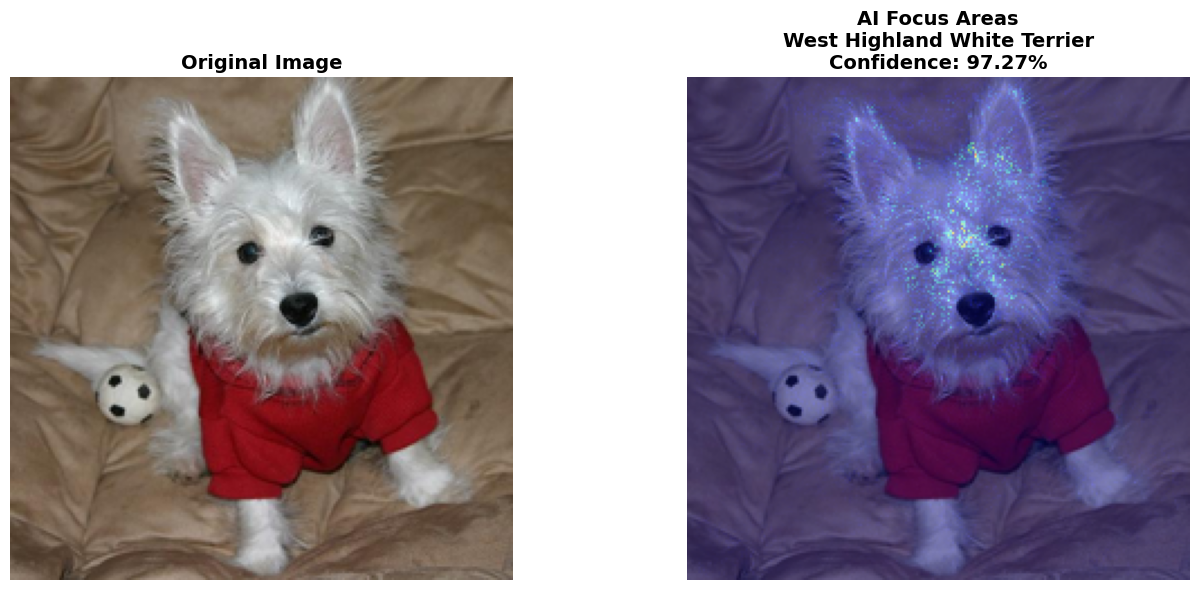


VISUALIZATION COMPLETE
✓ Combined view:  presentation_assets/integrated_gradients_combined.png
✓ Overlay only:   presentation_assets/integrated_gradients_overlay.png
✓ Original image: presentation_assets/integrated_gradients_original.png

💡 Interpretation:
   Red/yellow areas = high importance for classification
   Blue/dark areas  = low importance


In [40]:
import cv2
from tensorflow.keras.models import load_model

# Config
OUT_DIR = 'presentation_assets'
os.makedirs(OUT_DIR, exist_ok=True)
IMG_SIZE = (224, 224)
IG_STEPS = 30

print("="*60)
print("INTEGRATED GRADIENTS VISUALIZATION")
print("="*60)

# --- 1. SETUP MODEL & CLASS MAP ---
print("\n1. Loading model and class mapping...")

# Check if model is available
try:
    _ = model.predict
    print("   ✓ Using model from memory")
except (NameError, AttributeError):
    print("   Model not in memory, loading from file...")
    if os.path.exists('dog_breed_classifier.h5'):
        model = load_model('dog_breed_classifier.h5')
        print("   ✓ Loaded: dog_breed_classifier.h5")
    elif os.path.exists('best_model.h5'):
        model = load_model('best_model.h5')
        print("   ✓ Loaded: best_model.h5")
    else:
        raise FileNotFoundError("Model file not found!")

# Load class mapping
if 'train_gen' in globals() and hasattr(train_gen, 'class_indices'):
    class_map = train_gen.class_indices
    inv_class_map = {v: k for k, v in class_map.items()}
    print("   ✓ Using class indices from train_gen")
elif os.path.exists('class_indices.json'):
    with open('class_indices.json', 'r') as f:
        class_map = json.load(f)
    inv_class_map = {v: k for k, v in class_map.items()}
    print("   ✓ Loaded class indices from file")
else:
    raise FileNotFoundError(
        "Cannot find class mapping! Run Cell 4 or provide class_indices.json"
    )

# --- 2. RETRIEVE IMAGE FROM CELL 10 ---
print("\n2. Retrieving image...")

if 'shared_dog_image_path' in globals():
    img_path = shared_dog_image_path
    print(f"   ✓ Reusing image from Cell 10:\n     {img_path}")
else:
    print("   ⚠ No image from Cell 10. Selecting random image...")
    # Fallback: select random image
    if 'val_gen' in globals():
        img_path = random.choice(list(val_gen.filepaths))
    else:
        data_dir = '/kaggle/input/stanford-dogs-dataset/images/Images'
        all_files = []
        for root, _, files in os.walk(data_dir):
            for f in files:
                if f.lower().endswith(('.jpg', '.jpeg', '.png')):
                    all_files.append(os.path.join(root, f))
        img_path = random.choice(all_files)
    print(f"   Selected: {img_path}")

# --- 3. LOAD AND PREPROCESS ---
print("\n3. Preprocessing image...")
pil_img = Image.open(img_path).convert('RGB').resize(IMG_SIZE)
arr = image.img_to_array(pil_img) / 255.0
inp = np.expand_dims(arr, axis=0).astype(np.float32)

# --- 4. PREDICT ---
print("\n4. Making prediction...")
preds = model(inp, training=False).numpy()[0]
pred_idx = int(np.argmax(preds))

if pred_idx in inv_class_map:
    pred_name = inv_class_map[pred_idx].replace('_', ' ').title()
else:
    print(f"   ⚠ Warning: Index {pred_idx} not in class map")
    pred_name = f"Unknown Class {pred_idx}"

pred_conf = float(preds[pred_idx])
print(f"   Prediction: {pred_name} ({pred_conf:.2%})")

# Show Top-5
top5_idx = np.argsort(preds)[-5:][::-1]
print("\n   Top-5 predictions:")
for i, idx in enumerate(top5_idx, 1):
    name = inv_class_map.get(int(idx), str(idx)).replace('_', ' ').title()
    print(f"   {i}. {name:30s} {preds[int(idx)]:.3f}")

# --- 5. INTEGRATED GRADIENTS COMPUTATION ---
print("\n5. Computing Integrated Gradients...")

def integrated_gradients(model, inp, target_index, baseline=None, steps=30):
    """
    Compute Integrated Gradients attribution.
    
    Args:
        model: Keras model
        inp: Input image (1, H, W, 3)
        target_index: Target class index
        baseline: Baseline image (default: black image)
        steps: Number of interpolation steps
    
    Returns:
        Attribution map (H, W)
    """
    if baseline is None:
        baseline = np.zeros_like(inp).astype(np.float32)
    
    # Generate interpolation alphas
    alphas = np.linspace(0.0, 1.0, steps + 1)[:, None, None, None]
    total_grad = np.zeros_like(inp, dtype=np.float32)
    
    # Compute gradients at each interpolation step
    for alpha in alphas:
        interp = baseline + alpha * (inp - baseline)
        interp_tf = tf.convert_to_tensor(interp, dtype=tf.float32)
        
        with tf.GradientTape() as tape:
            tape.watch(interp_tf)
            preds = model(interp_tf, training=False)
            score = preds[:, target_index]
        
        grads = tape.gradient(score, interp_tf).numpy()
        total_grad += grads
    
    # Average gradients and compute attribution
    avg_grads = total_grad / (steps + 1)
    integrated = (inp - baseline) * avg_grads
    
    # Aggregate across color channels
    ig_map = np.mean(np.abs(integrated[0]), axis=-1)
    
    return ig_map

ig_map = integrated_gradients(model, inp, pred_idx, steps=IG_STEPS)
print(f"   ✓ Computed gradients with {IG_STEPS} steps")

# Normalize attribution map
ig_map = np.maximum(ig_map, 0)
if ig_map.max() > 0:
    ig_map = ig_map / ig_map.max()

# --- 6. VISUALIZATION ---
print("\n6. Creating visualization...")

# Create heatmap overlay
heat = (ig_map * 255).astype(np.uint8)
heat_color = cv2.applyColorMap(cv2.resize(heat, IMG_SIZE), cv2.COLORMAP_JET)
orig_bgr = cv2.cvtColor(np.array(pil_img), cv2.COLOR_RGB2BGR)
overlay_bgr = cv2.addWeighted(orig_bgr, 0.6, heat_color, 0.4, 0)
overlay_rgb = cv2.cvtColor(overlay_bgr, cv2.COLOR_BGR2RGB)

# Create side-by-side comparison
fig = plt.figure(figsize=(14, 6))

# Left: Original image
ax1 = plt.subplot(1, 2, 1)
ax1.imshow(pil_img)
ax1.axis('off')
ax1.set_title("Original Image", fontsize=14, fontweight='bold')

# Right: Overlay with heatmap
ax2 = plt.subplot(1, 2, 2)
ax2.imshow(overlay_rgb)
ax2.axis('off')
ax2.set_title(
    f"AI Focus Areas\n{pred_name}\nConfidence: {pred_conf:.2%}",
    fontsize=14,
    fontweight='bold'
)

plt.tight_layout()
save_path_combined = os.path.join(OUT_DIR, 'integrated_gradients_combined.png')
plt.savefig(save_path_combined, dpi=300, bbox_inches='tight')
plt.show()

# Also save overlay separately for presentations
fig_overlay = plt.figure(figsize=(8, 8))
plt.imshow(overlay_rgb)
plt.axis('off')
plt.title(f"{pred_name}\n{pred_conf:.2%}", fontsize=16, fontweight='bold')
plt.tight_layout()
save_path_overlay = os.path.join(OUT_DIR, 'integrated_gradients_overlay.png')
plt.savefig(save_path_overlay, dpi=300, bbox_inches='tight')
plt.close()

# Save original separately too
save_path_orig = os.path.join(OUT_DIR, 'integrated_gradients_original.png')
pil_img.save(save_path_orig)

print("\n" + "="*60)
print("VISUALIZATION COMPLETE")
print("="*60)
print(f"✓ Combined view:  {save_path_combined}")
print(f"✓ Overlay only:   {save_path_overlay}")
print(f"✓ Original image: {save_path_orig}")
print("\n💡 Interpretation:")
print("   Red/yellow areas = high importance for classification")
print("   Blue/dark areas  = low importance")
print("="*60)

_Результат: на экране отображаются два изображения. Слева — оригинал, справа — наложение тепловой карты, показывающей важные признаки, на которые опиралась нейросеть при классификации._